In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle

from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from imblearn.under_sampling import RandomUnderSampler

import warnings; warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'imblearn'

In [88]:
"""
import nltk

nltk.download('punkt')
"""

[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
recipes = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_recipes1.csv',index_col=0)
for i in [2,3,4,5]:
    recipes_append = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_recipes'+str(i)+'.csv',index_col=0)
    recipes = pd.concat([recipes,recipes_append],ignore_index=True)
recipes.set_index('id',inplace=True)

recipes

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
id,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...
486161,zydeco soup,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
493372,zydeco spice mix,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
308080,zydeco ya ya deviled eggs,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8


In [4]:
interactions = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_interactions1.csv',index_col=0)
for i in [2,3,4,5]:
    inappend = pd.read_csv('https://raw.githubusercontent.com/mpc02002/Food.com_data/master/datasets-raw/RAW_interactions'+str(i)+'.csv',index_col=0)
    interactions = pd.concat([interactions,inappend],ignore_index=True)

interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [5]:
interactions['date'] = pd.to_datetime(interactions['date'])

In [6]:
interactions['date'].iloc[0]

Timestamp('2003-02-17 00:00:00')

In [7]:
interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [8]:
T = 100  #set threshold parameter for "popular recipe"
t1 = pd.Timestamp('2016-12-31') #set initial time parameter upon which to base predictions.  Constraint:  t1 > 01-01-2001 + (t2 - t1)
t2 = pd.Timestamp('2018-01-30') #set prediction time parameter

In [9]:
days = pd.Timedelta((((t2 - t1).days // 365) + 1)*365,unit='D')

m1 = t1 - days # go back to previous time for model-training purposes
m2 = m1 + (t2 - t1)

m1,m2

(Timestamp('2015-01-01 00:00:00'), Timestamp('2016-01-31 00:00:00'))

In [10]:
interactions_pre_m1 = interactions[interactions['date'] <= m1]
interactions_pre_m2 = interactions[interactions['date'] <= m2]
interactions_pre_t1 = interactions[interactions['date'] <= t1]
interactions_pre_t2 = interactions[interactions['date'] <= t2]

recipe_ratings_count_m1 = (interactions_pre_m1.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_m1'}))
recipe_ratings_count_m2 = (interactions_pre_m2.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_m2'}))
recipe_ratings_count_t1 = (interactions_pre_t1.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_t1'}))
recipe_ratings_count_t2 = (interactions_pre_t2.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_t2'}))
recipe_ratings_count = pd.merge(recipe_ratings_count_m1,recipe_ratings_count_m2,how='outer',left_index=True,right_index=True)
recipe_ratings_count = pd.merge(recipe_ratings_count,recipe_ratings_count_t1,how='outer',left_index=True,right_index=True)
recipe_ratings_count = pd.merge(recipe_ratings_count,recipe_ratings_count_t2,how='outer',left_index=True,right_index=True)
recipe_ratings_count['total_ratings_at_m1'] = recipe_ratings_count['total_ratings_at_m1'].fillna(0).astype(int)
recipe_ratings_count['total_ratings_at_m2'] = recipe_ratings_count['total_ratings_at_m2'].fillna(0).astype(int)
recipe_ratings_count['total_ratings_at_t1'] = recipe_ratings_count['total_ratings_at_t1'].fillna(0).astype(int)
recipe_ratings_count

,total_ratings_at_m1,total_ratings_at_m2,total_ratings_at_t1,total_ratings_at_t2
recipe_id,,,,
38,4,4,4,4
39,1,1,1,1
40,9,9,9,9
41,2,2,2,2
43,1,1,1,1
...,...,...,...,...
534635,0,0,0,1
534784,0,0,0,1
534868,0,0,0,1


In [11]:
recipe_ratings_count[recipe_ratings_count['total_ratings_at_m2'] >= T]

,total_ratings_at_m1,total_ratings_at_m2,total_ratings_at_t1,total_ratings_at_t2
recipe_id,,,,
607,133,136,139,143
749,178,184,186,190
916,91,102,107,109
1005,128,128,128,129
1356,164,197,217,264
...,...,...,...,...
348802,150,156,161,166
349246,122,176,192,273
486261,216,216,217,217


In [12]:
recipe_ratings_count[recipe_ratings_count['total_ratings_at_m2'] < T]

,total_ratings_at_m2,total_ratings_at_t2
recipe_id,,
38,4,4
39,1,1
40,9,9
41,2,2
43,1,1
...,...,...
534635,0,1
534784,0,1
534868,0,1


In [13]:
recipe_ratings_count[recipe_ratings_count['total_ratings_at_t2'] >= T]

,total_ratings_at_m2,total_ratings_at_t2
recipe_id,,
607,136,143
749,184,190
916,102,109
1005,128,129
1356,197,264
...,...,...
443758,50,108
486261,216,217
486496,202,202


In [14]:
recipe_ratings_count[recipe_ratings_count['total_ratings_at_t2'] < T]

,total_ratings_at_m2,total_ratings_at_t2
recipe_id,,
38,4,4
39,1,1
40,9,9
41,2,2
43,1,1
...,...,...
534635,0,1
534784,0,1
534868,0,1


In [11]:
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(m1) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_m1'] >= T]) 
          / len(recipe_ratings_count)) + '.')
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(m2) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_m2'] >= T]) 
          / len(recipe_ratings_count)) + '.')
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(t1) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_t1'] >= T]) 
          / len(recipe_ratings_count)) + '.')
print('The proportion of recipes with at least ' + str(T) + ' ratings on ' + str(t2) + ' is ' + 
      str(len(recipe_ratings_count[recipe_ratings_count['total_ratings_at_t2'] >= T]) 
          / len(recipe_ratings_count)) + '.')

The proportion of recipes with at least 100 ratings on 2015-01-01 00:00:00 is 0.002884106620867921.
The proportion of recipes with at least 100 ratings on 2016-01-31 00:00:00 is 0.0029968686842402007.
The proportion of recipes with at least 100 ratings on 2016-12-31 00:00:00 is 0.003083608732988108.
The proportion of recipes with at least 100 ratings on 2018-01-30 00:00:00 is 0.003322143867044853.


In [11]:
recipe_ratings_count['m1_target'] = recipe_ratings_count['total_ratings_at_m1'].map(lambda x: x >= T).astype(int)
recipe_ratings_count['m2_target'] = recipe_ratings_count['total_ratings_at_m2'].map(lambda x: x >= T).astype(int)
recipe_ratings_count['t1_target'] = recipe_ratings_count['total_ratings_at_t1'].map(lambda x: x >= T).astype(int)
recipe_ratings_count['t2_target'] = recipe_ratings_count['total_ratings_at_t2'].map(lambda x: x >= T).astype(int)
recipe_ratings_count

,total_ratings_at_m1,total_ratings_at_m2,total_ratings_at_t1,total_ratings_at_t2,m1_target,m2_target,t1_target,t2_target
recipe_id,,,,,,,,
38,4,4,4,4,0,0,0,0
39,1,1,1,1,0,0,0,0
40,9,9,9,9,0,0,0,0
41,2,2,2,2,0,0,0,0
43,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
534635,0,0,0,1,0,0,0,0
534784,0,0,0,1,0,0,0,0
534868,0,0,0,1,0,0,0,0


In [17]:
df = pd.merge(recipe_ratings_count['m2_target'],
             recipes[['minutes','submitted','n_steps','n_ingredients']],
             how = 'left',left_index=True, right_index=True)

df

,m2_target,minutes,submitted,n_steps,n_ingredients
recipe_id,,,,,
38,0,1485,1999-08-09,13,4
39,0,265,1999-08-29,17,26
40,0,35,1999-09-05,8,6
41,0,1460,1999-09-03,18,15
43,0,140,1999-08-21,35,15
...,...,...,...,...,...
534635,0,60,2017-12-12,8,7
534784,0,5,2018-01-02,9,9
534868,0,35,2018-01-10,28,15


In [18]:
df['submitted'] = pd.to_datetime(df['submitted'])
df = df[df['submitted'] <= m1]
df

,m2_target,minutes,submitted,n_steps,n_ingredients
recipe_id,,,,,
38,0,1485,1999-08-09,13,4
39,0,265,1999-08-29,17,26
40,0,35,1999-09-05,8,6
41,0,1460,1999-09-03,18,15
43,0,140,1999-08-21,35,15
...,...,...,...,...,...
520245,0,35,2014-12-29,10,6
520248,0,15,2014-12-29,9,7
520250,0,30,2014-12-29,11,12


In [19]:
interactions_pre_m1 = interactions[interactions['date'] <= m1]
#interactions_pre_t2

df['total_ratings_at_m1'] = (interactions_pre_m1.groupby('recipe_id').agg({'rating':'count'})
    .rename(columns={'rating':'total_ratings_at_m1'}))
df['total_ratings_at_m1'] = df['total_ratings_at_m1'].fillna(0).astype(int)
df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1
recipe_id,,,,,,
38,0,1485,1999-08-09,13,4,4
39,0,265,1999-08-29,17,26,1
40,0,35,1999-09-05,8,6,9
41,0,1460,1999-09-03,18,15,2
43,0,140,1999-08-21,35,15,1
...,...,...,...,...,...,...
520245,0,35,2014-12-29,10,6,0
520248,0,15,2014-12-29,9,7,1
520250,0,30,2014-12-29,11,12,1


In [20]:
df = df[df['total_ratings_at_m1'] < T]
df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1
recipe_id,,,,,,
38,0,1485,1999-08-09,13,4,4
39,0,265,1999-08-29,17,26,1
40,0,35,1999-09-05,8,6,9
41,0,1460,1999-09-03,18,15,2
43,0,140,1999-08-21,35,15,1
...,...,...,...,...,...,...
520245,0,35,2014-12-29,10,6,0
520248,0,15,2014-12-29,9,7,1
520250,0,30,2014-12-29,11,12,1


In [21]:
df['age_in_days'] = ((m1 - df['submitted']) / pd.Timedelta(1,'D')).astype(int)
df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days
recipe_id,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624
39,0,265,1999-08-29,17,26,1,5604
40,0,35,1999-09-05,8,6,9,5597
41,0,1460,1999-09-03,18,15,2,5599
43,0,140,1999-08-21,35,15,1,5612
...,...,...,...,...,...,...,...
520245,0,35,2014-12-29,10,6,0,3
520248,0,15,2014-12-29,9,7,1,3
520250,0,30,2014-12-29,11,12,1,3


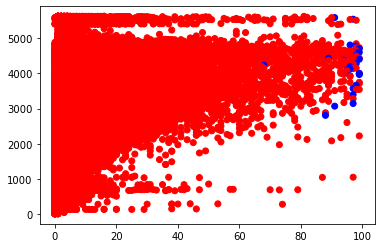

In [28]:
x = df['total_ratings_at_m1']
y = df['age_in_days']
color = df['m2_target'].map(lambda x: 'blue' if x==1 else 'red')

plt.scatter(x,y,color=color)
plt.show()

In [12]:
infile = project.get_file("ingr_map.pkl")
ingr_map = pickle.load(infile)
infile.close()
ingr_map.set_index('id',inplace=True)
ingr_map

,raw_ingr,raw_words,processed,len_proc,replaced,count
id,,,,,,
4308,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507
4308,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507
4308,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507
4308,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507
4308,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507
...,...,...,...,...,...,...
6702,soybeans,1,soybean,7,soybean,31
3318,goose,1,goose,5,goose,8
47,ajwain,1,ajwain,6,ajwain,13


In [13]:
recipes_cleaned1 = pd.read_csv(project.get_file('PP_recipes1.csv'),index_col=0)
recipes_cleaned2 = pd.read_csv(project.get_file('PP_recipes2.csv'),index_col=0)
recipes_cleaned3 = pd.read_csv(project.get_file('PP_recipes3.csv'),index_col=0)
recipes_cleaned = pd.concat([recipes_cleaned1,recipes_cleaned2,recipes_cleaned3])

recipes_cleaned

,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
id,,,,,,,
424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"
...,...,...,...,...,...,...,...
323143,76862,"[40480, 6444, 1964, 9369, 486, 569, 17551, 40481]","[[8780], [11835, 1762, 4465, 31494], [6812], [...","[40480, 40482, 729, 2525, 715, 485, 26641, 404...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[840, 208, 2499, 2683, 1925, 335, 1511]"
149114,145962,"[40480, 17027, 24715, 974, 11877, 40481]","[[6812], [5940], [30645, 4785, 6821], [6953], ...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[2499, 4717, 1168, 6270, 6324, 7040]"
34200,65066,"[40480, 12187, 11434, 1738, 2627, 40481]","[[6167, 20930, 510], [1353], [15022, 6953], [6...","[40480, 40482, 500, 246, 1719, 5024, 240, 2366...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[2378, 7655, 3219, 2320, 5168, 5319, 4189, 268..."


In [14]:
tokenizer = RegexpTokenizer(r'\d+')

recipes_to_ingrs = recipes_cleaned['ingredient_ids']
recipes_to_ingrs = recipes_to_ingrs.map(tokenizer.tokenize).to_frame().explode('ingredient_ids')

recipes_to_ingrs.reset_index(inplace=True)

recipes_to_ingrs.rename(columns={'id':'recipe_id','ingredient_ids':'ingr_id'},inplace=True)
recipes_to_ingrs = recipes_to_ingrs.astype('int')

recipes_to_ingrs

,recipe_id,ingr_id
0,424415,389
1,424415,7655
2,424415,6270
3,424415,1527
4,424415,3406
...,...,...
1605467,263840,335
1605468,263840,1563
1605469,263840,1511
1605470,263840,3248


In [15]:
ingr_recipe_count = recipes_to_ingrs.groupby('ingr_id').count()
ingr_recipe_count.index = ingr_recipe_count.index.astype('int')
ingr_recipe_count.sort_index(inplace=True)
ingr_recipe_count.rename(columns={'recipe_id':'recipe_count'},inplace=True)

ingr_recipe_count

,recipe_count
ingr_id,
0,1
1,13
2,6
3,4
4,1
...,...
8018,30
8019,187
8020,1


In [16]:
ingr_recipe_count.describe()

,recipe_count
count,7993.000000
mean,200.859752
std,1531.835389
min,1.000000
25%,3.000000
50%,10.000000
75%,46.000000
max,66483.000000


In [17]:
recipes_to_sig_ingrs = pd.merge(recipes_to_ingrs,ingr_recipe_count,how='left',left_on='ingr_id',right_index=True)
recipes_to_sig_ingrs = recipes_to_sig_ingrs[recipes_to_sig_ingrs['recipe_count'] >= 50]
recipes_to_sig_ingrs

,recipe_id,ingr_id,recipe_count
0,424415,389,380
1,424415,7655,25953
2,424415,6270,66483
3,424415,1527,1383
4,424415,3406,67
...,...,...,...
1605467,263840,335,11276
1605468,263840,1563,1450
1605469,263840,1511,9958
1605470,263840,3248,2797


In [18]:
edges = recipes_to_sig_ingrs[['recipe_id','ingr_id']]
edges['ingr_id'] = edges['ingr_id'].astype('float') / 10000
edges

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,recipe_id,ingr_id
0,424415,0.0389
1,424415,0.7655
2,424415,0.6270
3,424415,0.1527
4,424415,0.3406
...,...,...
1605467,263840,0.0335
1605468,263840,0.1563
1605469,263840,0.1511
1605470,263840,0.3248


In [19]:
G = nx.from_pandas_edgelist(edges,'recipe_id','ingr_id')

In [30]:
G.nodes()

NodeView((424415, 0.0389, 0.7655, 0.627, 0.1527, 0.3406, 146223, 0.2683, 0.4969, 0.08, 0.5298, 0.084, 0.2499, 0.6632, 0.7022, 0.1511, 0.3248, 0.4964, 312329, 0.1257, 0.059, 0.5024, 0.1119, 0.4883, 0.6696, 0.7946, 0.5648, 0.7705, 0.7594, 0.1168, 74301, 0.794, 0.3609, 0.706, 0.6265, 0.117, 0.6654, 0.5003, 0.3561, 76272, 0.3484, 0.6324, 465171, 0.6861, 0.6846, 0.6906, 0.1789, 0.0131, 0.1833, 0.1909, 163861, 0.5574, 0.5319, 0.0869, 0.4987, 186383, 0.0332, 0.0335, 0.747, 0.6706, 0.1388, 116395, 0.1689, 0.5687, 0.1098, 0.191, 0.7449, 0.4253, 303460, 0.6413, 0.7997, 0.371, 0.1799, 0.2007, 0.3203, 0.2654, 0.1316, 408927, 0.1881, 0.6426, 0.3957, 0.474, 0.6009, 0.2809, 0.509, 0.4284, 331329, 0.23, 0.501, 0.1504, 0.5006, 0.6272, 0.7213, 330169, 0.0912, 0.4717, 0.5093, 0.7557, 0.4611, 0.0163, 289290, 0.1252, 0.6711, 0.3184, 0.6715, 288683, 0.1375, 0.1589, 0.2181, 154406, 0.0715, 0.3412, 0.1803, 0.7228, 0.381, 0.7754, 102015, 0.7783, 0.1917, 0.1914, 0.192, 0.6443, 0.4449, 0.518, 0.5168, 60244, 0.10

In [31]:
nx.is_bipartite(G)

True

In [32]:
sig_ingrs = edges['ingr_id'].unique().tolist()

len(sig_ingrs)

1917

In [33]:
recipe_ids = edges['recipe_id'].unique()

test_recipe = recipe_ids[0]

test_recipe_duplicates = np.array([test_recipe for i in recipe_ids])

test_recipe_pairs = pd.DataFrame(test_recipe_duplicates)
test_recipe_pairs[1] = recipe_ids
test_recipe_pairs

,0,1
0,424415,424415
1,424415,146223
2,424415,312329
3,424415,74301
4,424415,76272
...,...,...
178250,424415,323143
178251,424415,149114
178252,424415,34200
178253,424415,30618


In [62]:
jaccard_coeffs = [p for u,v,p in nx.jaccard_coefficient(G,zip(test_recipe_pairs[0],test_recipe_pairs[1]))]

In [63]:
len(jaccard_coeffs)

178255

In [66]:
test_recipe_pairs['jaccard_coeffs'] = jaccard_coeffs
test_recipe_pairs

,0,1,jaccard_coeffs
0,424415,424415,1.000000
1,424415,146223,0.062500
2,424415,312329,0.117647
3,424415,74301,0.000000
4,424415,76272,0.000000
...,...,...,...
178250,424415,323143,0.000000
178251,424415,149114,0.100000
178252,424415,34200,0.055556
178253,424415,30618,0.000000


In [68]:
max(jaccard_coeffs[1:])

0.5714285714285714

In [66]:
df = df.loc[df.index.isin(edges['recipe_id'])]

In [70]:
popular_recipes = df[df['total_ratings_at_m1'] >= 50].index.to_list()
popular_recipes = [r for r in popular_recipes if r in G.nodes()]
#recipe_pairs = list(product(popular_recipes, df.index))#pd.DataFrame(list(product(popular_recipes, df.index)),columns=['popular_recipe','recipe'])

df['innovation_jaccard'] = [None for i in df.index]
df['innovation_jaccard_avg'] = [None for i in df.index]

df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,None,None
40,0,35,1999-09-05,8,6,9,5597,None,None
45,0,80,1999-08-06,10,9,3,5627,None,None
46,0,25,1999-08-11,5,6,2,5622,None,None
49,0,75,1999-08-14,22,10,18,5619,None,None
...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,None,None
520088,0,40,2014-12-21,9,6,1,11,None,None
520245,0,35,2014-12-29,10,6,0,3,None,None


In [71]:
#  Danger zone!!  This script takes ~75 minutes to run

"""
for r in df.index:
    r_duplicates = np.array([r for i in popular_recipes])
    jaccard_coeffs = [p for u,v,p in nx.jaccard_coefficient(G,zip(r_duplicates,popular_recipes))]
    df['innovation_jaccard'].loc[r] = 1 - max(jaccard_coeffs)
    df['innovation_jaccard_avg'].loc[r] = 1 - np.mean(jaccard_coeffs)

project.save_data('features_train.csv', df.to_csv(), set_project_asset=True, overwrite=True)

df
"""

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.8,0.991975
40,0,35,1999-09-05,8,6,9,5597,0.5,0.979425
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262
...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048


In [74]:
print('The number of recipes with innovation_jaccard equal to 0 is ' + 
      str(len(df[df['innovation_jaccard'] == 0])) + '.')

The number of recipes with innovation_jaccard equal to 0 is 1155.


In [75]:
df[df['innovation_jaccard'] == 0]

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,
246,0,45,1999-09-01,8,10,63,5601,0,0.969298
536,0,60,1999-09-07,18,10,66,5595,0,0.939014
632,0,70,1999-09-05,7,7,82,5597,0,0.982602
809,0,150,1999-08-28,10,13,50,5605,0,0.974267
860,0,23,1999-08-26,9,6,78,5607,0,0.909956
...,...,...,...,...,...,...,...,...,...
486267,0,35,2012-09-01,15,9,50,852,0,0.955691
494435,0,15,2013-01-30,5,13,57,701,0,0.987577
495271,0,40,2013-02-11,7,9,79,689,0,0.962877


In [80]:
recipes.loc[494435]

name                                crab ranch gorgonzola slaw  rsc
minutes                                                          15
contributor_id                                              2216338
submitted                                                2013-01-30
tags              ['weeknight', '15-minutes-or-less', 'time-to-m...
nutrition                [180.7, 14.0, 15.0, 33.0, 30.0, 17.0, 3.0]
n_steps                                                           5
steps             ['combine dressing ingredients in a large mixi...
description       ready, set, cook! hidden valley contest entry:...
ingredients       ['coleslaw mix', 'crabmeat', 'grape tomatoes',...
n_ingredients                                                    13
Name: 494435, dtype: object

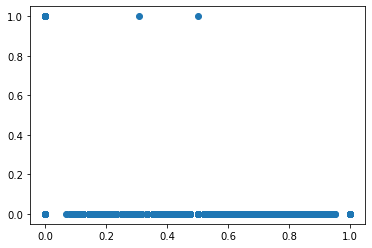

In [93]:
plt.scatter(df['innovation_jaccard'],df['target'])
plt.show()

In [34]:

"""

popular_recipes = df[df['total_ratings_at_t1'] >= 50].index.to_list()
popular_recipes = [r for r in popular_recipes if r in G.nodes()]

df['innovation_jaccard_avg'] = [None for i in df.index]

for r in df.index:
    r_duplicates = np.array([r for i in popular_recipes])
    jaccard_coeffs = [p for u,v,p in nx.jaccard_coefficient(G,zip(r_duplicates,popular_recipes))]
    df['innovation_jaccard_avg'].loc[r] = 1 - np.mean(jaccard_coeffs)

project.save_data('features.csv', df.to_csv(), set_project_asset=True, overwrite=True)

df

"""

,target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_t1,days_since_Jan_1_1999,innovation_jaccard,innovation_jaccard_avg
recipe_id,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,220,0.800000,0.992235
40,0,35,1999-09-05,8,6,9,247,0.500000,0.979448
45,0,80,1999-08-06,10,9,3,217,0.545455,0.918305
46,0,25,1999-08-11,5,6,2,222,0.888889,0.999639
49,0,75,1999-08-14,22,10,19,225,0.545455,0.923934
...,...,...,...,...,...,...,...,...,...
524958,0,45,2015-11-30,13,10,13,6177,0.700000,0.96684
524962,0,50,2015-11-30,13,14,0,6177,0.647059,0.953152
524992,0,30,2015-12-01,15,13,2,6178,0.750000,0.95025


In [23]:
df = pd.read_csv(project.get_file('features_train.csv'),index_col=0)

df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score,mean_rating_at_m1
recipe_id,,,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744,28.360140,4.250000
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270,15.944444,4.333333
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416,27.642857,2.666667
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127,28.749153,5.000000
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300,32.621735,4.277778
...,...,...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198,36.532448,5.000000
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775,26.073707,0.000000
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980,31.076623,NaN


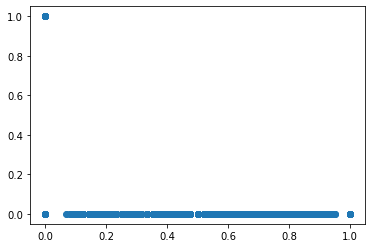

In [42]:
plt.scatter(df['innovation_jaccard'],df['m2_target'])
plt.show()

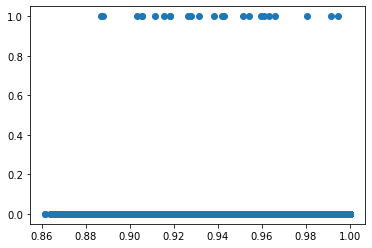

In [43]:
plt.scatter(df['innovation_jaccard_avg'],df['m2_target'])
plt.show()

In [36]:
num_recipes = len(recipes_to_sig_ingrs.index.unique())

recipes_to_sig_ingrs['ingr_rareness'] = recipes_to_sig_ingrs['recipe_count'] / num_recipes

recipes_to_sig_ingrs

,recipe_id,ingr_id,recipe_count,ingr_rareness
0,424415,389,380,0.000247
1,424415,7655,25953,0.016863
2,424415,6270,66483,0.043198
3,424415,1527,1383,0.000899
4,424415,3406,67,0.000044
...,...,...,...,...
1605467,263840,335,11276,0.007327
1605468,263840,1563,1450,0.000942
1605469,263840,1511,9958,0.006470
1605470,263840,3248,2797,0.001817


In [37]:
ingr_rareness_sums = recipes_to_sig_ingrs.groupby('recipe_id').agg({'ingr_rareness':'sum'}).rename(columns={'ingr_rareness':'ingr_rareness_sum'})
ingr_rareness_sums

,ingr_rareness_sum
recipe_id,
38,0.010976
40,0.025621
45,0.111747
46,0.000762
49,0.113004
...,...
537175,0.084208
537319,0.030098
537458,0.120479


In [38]:
ingr_rareness_info = pd.merge(df['n_ingredients'],ingr_rareness_sums,how='left',left_index=True,right_index=True)
ingr_rareness_info['innovation_IDF'] = ingr_rareness_info['ingr_rareness_sum'] / ingr_rareness_info['n_ingredients']
ingr_rareness_info

,n_ingredients,ingr_rareness_sum,innovation_IDF
recipe_id,,,
38,4,0.010976,0.002744
40,6,0.025621,0.004270
45,9,0.111747,0.012416
46,6,0.000762,0.000127
49,10,0.113004,0.011300
...,...,...,...
520055,13,0.041578,0.003198
520088,6,0.064649,0.010775
520245,6,0.083881,0.013980


In [39]:
df = pd.merge(df,ingr_rareness_info['innovation_IDF'],how='left',left_index=True,right_index=True)

df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF
recipe_id,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300
...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980


In [52]:
simple_word_tokenizer = RegexpTokenizer(r'\w+')

readability_df = recipes['steps'].to_frame().fillna('')
readability_df['steps_word_tokenized'] = readability_df['steps'].apply(simple_word_tokenizer.tokenize)

readability_df

,steps,steps_word_tokenized
id,,
137739,"['make a choice and proceed with recipe', 'dep...","[make, a, choice, and, proceed, with, recipe, ..."
31490,"['preheat oven to 425 degrees f', 'press dough...","[preheat, oven, to, 425, degrees, f, press, do..."
112140,"['brown ground beef in large pot', 'add choppe...","[brown, ground, beef, in, large, pot, add, cho..."
59389,['place potatoes in a large pot of lightly sal...,"[place, potatoes, in, a, large, pot, of, light..."
44061,['mix all ingredients& boil for 2 1 / 2 hours ...,"[mix, all, ingredients, boil, for, 2, 1, 2, ho..."
...,...,...
486161,"['heat oil in a 4-quart dutch oven', 'add cele...","[heat, oil, in, a, 4, quart, dutch, oven, add,..."
493372,['mix all ingredients together thoroughly'],"[mix, all, ingredients, together, thoroughly]"
308080,"['in a bowl , combine the mashed yolks and may...","[in, a, bowl, combine, the, mashed, yolks, and..."


In [54]:
readability_df['long_words'] = readability_df['steps_word_tokenized'].apply(lambda x: [word for word in x if len(word) > 6])
readability_df

,steps,steps_word_tokenized,long_words
id,,,
137739,"['make a choice and proceed with recipe', 'dep...","[make, a, choice, and, proceed, with, recipe, ...","[proceed, depending, fourths, drizzle, mexican..."
31490,"['preheat oven to 425 degrees f', 'press dough...","[preheat, oven, to, 425, degrees, f, press, do...","[preheat, degrees, minutes, browned, sausage, ..."
112140,"['brown ground beef in large pot', 'add choppe...","[brown, ground, beef, in, large, pot, add, cho...","[chopped, ingredients, lettuce, shredded]"
59389,['place potatoes in a large pot of lightly sal...,"[place, potatoes, in, a, large, pot, of, light...","[potatoes, lightly, potatoes, potatoes, ingred..."
44061,['mix all ingredients& boil for 2 1 / 2 hours ...,"[mix, all, ingredients, boil, for, 2, 1, 2, ho...","[ingredients, ketchup, bottles, necessary]"
...,...,...,...
486161,"['heat oil in a 4-quart dutch oven', 'add cele...","[heat, oil, in, a, 4, quart, dutch, oven, add,...","[minutes, paprika, mustard, oregano, cayenne, ..."
493372,['mix all ingredients together thoroughly'],"[mix, all, ingredients, together, thoroughly]","[ingredients, together, thoroughly]"
308080,"['in a bowl , combine the mashed yolks and may...","[in, a, bowl, combine, the, mashed, yolks, and...","[combine, mayonnaise, mustard, seasoning, taba..."


In [56]:
readability_df = pd.merge(readability_df, recipes['n_steps'],how='left',left_index=True,right_index=True)

In [57]:
readability_df['num_words'] = readability_df['steps_word_tokenized'].apply(lambda x: len(x))
readability_df['num_long_words'] = readability_df['long_words'].apply(lambda x: len(x))

readability_df

,steps,steps_word_tokenized,long_words,n_steps,num_words,num_long_words
id,,,,,,
137739,"['make a choice and proceed with recipe', 'dep...","[make, a, choice, and, proceed, with, recipe, ...","[proceed, depending, fourths, drizzle, mexican...",11,123,17
31490,"['preheat oven to 425 degrees f', 'press dough...","[preheat, oven, to, 425, degrees, f, press, do...","[preheat, degrees, minutes, browned, sausage, ...",9,76,10
112140,"['brown ground beef in large pot', 'add choppe...","[brown, ground, beef, in, large, pot, add, cho...","[chopped, ingredients, lettuce, shredded]",6,57,4
59389,['place potatoes in a large pot of lightly sal...,"[place, potatoes, in, a, large, pot, of, light...","[potatoes, lightly, potatoes, potatoes, ingred...",11,99,19
44061,['mix all ingredients& boil for 2 1 / 2 hours ...,"[mix, all, ingredients, boil, for, 2, 1, 2, ho...","[ingredients, ketchup, bottles, necessary]",5,57,4
...,...,...,...,...,...,...
486161,"['heat oil in a 4-quart dutch oven', 'add cele...","[heat, oil, in, a, 4, quart, dutch, oven, add,...","[minutes, paprika, mustard, oregano, cayenne, ...",7,76,14
493372,['mix all ingredients together thoroughly'],"[mix, all, ingredients, together, thoroughly]","[ingredients, together, thoroughly]",1,5,3
308080,"['in a bowl , combine the mashed yolks and may...","[in, a, bowl, combine, the, mashed, yolks, and...","[combine, mayonnaise, mustard, seasoning, taba...",7,43,9


In [58]:
readability_df['LIX_score'] = 100 * readability_df['num_long_words'] / readability_df['num_words'] + readability_df['num_words'] / readability_df['n_steps']

readability_df

,steps,steps_word_tokenized,long_words,n_steps,num_words,num_long_words,LIX_score
id,,,,,,,
137739,"['make a choice and proceed with recipe', 'dep...","[make, a, choice, and, proceed, with, recipe, ...","[proceed, depending, fourths, drizzle, mexican...",11,123,17,25.002956
31490,"['preheat oven to 425 degrees f', 'press dough...","[preheat, oven, to, 425, degrees, f, press, do...","[preheat, degrees, minutes, browned, sausage, ...",9,76,10,21.602339
112140,"['brown ground beef in large pot', 'add choppe...","[brown, ground, beef, in, large, pot, add, cho...","[chopped, ingredients, lettuce, shredded]",6,57,4,16.517544
59389,['place potatoes in a large pot of lightly sal...,"[place, potatoes, in, a, large, pot, of, light...","[potatoes, lightly, potatoes, potatoes, ingred...",11,99,19,28.191919
44061,['mix all ingredients& boil for 2 1 / 2 hours ...,"[mix, all, ingredients, boil, for, 2, 1, 2, ho...","[ingredients, ketchup, bottles, necessary]",5,57,4,18.417544
...,...,...,...,...,...,...,...
486161,"['heat oil in a 4-quart dutch oven', 'add cele...","[heat, oil, in, a, 4, quart, dutch, oven, add,...","[minutes, paprika, mustard, oregano, cayenne, ...",7,76,14,29.278195
493372,['mix all ingredients together thoroughly'],"[mix, all, ingredients, together, thoroughly]","[ingredients, together, thoroughly]",1,5,3,65.000000
308080,"['in a bowl , combine the mashed yolks and may...","[in, a, bowl, combine, the, mashed, yolks, and...","[combine, mayonnaise, mustard, seasoning, taba...",7,43,9,27.073090


In [61]:
df = pd.merge(df,readability_df['LIX_score'],how='left',left_index=True,right_index=True)

df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score
recipe_id,,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744,28.360140
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270,15.944444
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416,27.642857
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127,28.749153
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300,32.621735
...,...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198,36.532448
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775,26.073707
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980,31.076623


In [62]:
project.save_data('features_train.csv', df.to_csv(), set_project_asset=True, overwrite=True)

{'file_name': 'features_train.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'foodcomrecipepopularitypredictor-donotdelete-pr-wiqbzxzcs7ksbf',
 'asset_id': '07aeab73-aeed-4054-9647-d200350af9cf'}

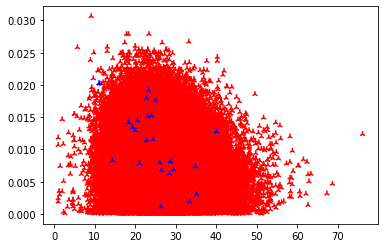

In [66]:
x = df['LIX_score']
y = df['innovation_IDF']
color = df['m2_target'].map(lambda x: 'blue' if x==1 else 'red')

plt.scatter(x,y,color=color,marker="2")

x_good = df['LIX_score'].loc[df['m2_target'] == 1]
y_good = df['innovation_IDF'].loc[df['m2_target'] == 1]

plt.scatter(x_good,y_good,color='blue',marker="2")
plt.show()

In [21]:
inters_pre_m1 = interactions.loc[interactions['date'] < m1]
inters_pre_m1

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132361,102526,54493,2007-04-26,0,I am not going to rate this because I did have...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...


In [16]:
mean_rating_at_m1 = inters_pre_m1.groupby('recipe_id').mean().rename(columns={'rating':'mean_rating_at_m1'})
mean_rating_at_m1

,user_id,mean_rating_at_m1
recipe_id,,
38,4.516842e+08,4.250000
39,3.932540e+05,3.000000
40,4.048043e+05,4.333333
41,5.588705e+05,4.500000
43,1.060485e+06,1.000000
...,...,...
520055,1.803588e+09,5.000000
520067,2.505890e+05,5.000000
520088,2.196530e+05,0.000000


In [217]:
df = pd.merge(df,mean_rating_at_m1['mean_rating_at_m1'],how='left',left_index=True,right_index=True)

df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score,mean_rating_at_m1
recipe_id,,,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744,28.360140,4.250000
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270,15.944444,4.333333
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416,27.642857,2.666667
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127,28.749153,5.000000
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300,32.621735,4.277778
...,...,...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198,36.532448,5.000000
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775,26.073707,0.000000
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980,31.076623,NaN


In [218]:
project.save_data('features_train.csv', df.to_csv(), set_project_asset=True, overwrite=True)

{'file_name': 'features_train.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'foodcomrecipepopularitypredictor-donotdelete-pr-wiqbzxzcs7ksbf',
 'asset_id': '07aeab73-aeed-4054-9647-d200350af9cf'}

In [22]:
inters_pre_m1['review'].fillna('',inplace=True)
review_aggs = inters_pre_m1.groupby('recipe_id').agg({'review':(lambda x: ' '.join(x))})

review_aggs

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,review
recipe_id,
38,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,I have an Indian friend who made this dish for...
40,My favourite lemonade recipe is essentially th...
41,I thought this was very GOOD! ANYONE who is af...
43,did not work.
...,...
520055,Forget the takeout! This recipe took me to chi...
520067,WOWIE RATING FOR THIS SOUP!&lt;br/&gt; ...
520088,This recipe calls for walnuts and the instruct...


In [19]:
review_aggs['review'].loc[40893]

"Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt.  Used low fat sour cream.  Thanks. So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!"

In [24]:
NB_df = pd.merge(df['m2_target'],review_aggs['review'],how='left',left_index=True,right_index=True)

NB_df

,m2_target,review
recipe_id,,
38,0,"Yummy, yummy, yummy! I am a big fan of fruit a..."
40,0,My favourite lemonade recipe is essentially th...
45,0,This was my first buttermilk pie (I had never ...
46,0,"I used regular sugar, and when it came to the ..."
49,0,I give this recipe a good to high rating becau...
...,...,...
520055,0,Forget the takeout! This recipe took me to chi...
520088,0,This recipe calls for walnuts and the instruct...
520245,0,NaN


In [25]:
NB_df.rename(columns={'review':'review_agg'},inplace=True)

In [26]:
NB_df['review_agg'].fillna(' ',inplace=True)

In [27]:
vect = CountVectorizer(min_df=3).fit(NB_df['review_agg'])

In [28]:
NB_df_reviews_vectorized = vect.transform(NB_df['review_agg'])

In [23]:
"""
max_abs_scaler = MaxAbsScaler().fit(NB_df_reviews_vectorized)
NB_df_reviews_vectorized_scaled = max_abs_scaler.transform(NB_df_reviews_vectorized)
"""

In [139]:
NB_df[NB_df['m2_target'] == 1]

,m2_target,review_agg
recipe_id,,
916,1,"This is a great recipe, its small, quick and t..."
3745,1,My family Loves these muffins! Very easy to ma...
13619,1,"Oo, this turned out great!! I'm always scared..."
19253,1,"Not exactly the same as Applebees, but very cl..."
26451,1,Very good fish. It has plenty of flavor. Mad...
29413,1,Great combo. Easy to make and a big hit. Thank...
31314,1,I have made this casserole numerous time and i...
37437,1,This was excellent. Made for our final Christ...
46072,1,My husband never liked rice pudding till I mad...


In [154]:
NB_clfr = MultinomialNB()#.fit(NB_df_reviews_vectorized_scaled,NB_df['m2_target'])
cross_val_score(NB_clfr, NB_df_reviews_vectorized, NB_df['m2_target'], cv=10, scoring='roc_auc')

array([0.00643087, 0.0050488 , 0.00487984, 0.00310279, 0.0015796 ,
       0.00084621, 0.00045131, 0.00067697, 0.00016924, 0.00016924])

In [158]:
NB_df_reviews_vectorized

<177286x40259 sparse matrix of type '<class 'numpy.int64'>'
	with 19152561 stored elements in Compressed Sparse Row format>

In [161]:
X_train, X_test, y_train, y_test = train_test_split(
        NB_df_reviews_vectorized,
        NB_df['m2_target'],
        test_size=0.1
)

X_train.shape, y_train.shape

((159557, 40259), (159557,))

In [166]:
test_scores = []

for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        NB_df_reviews_vectorized,
        NB_df['m2_target'],
        test_size=0.2
    )

    NB_clfr.fit(X_train, y_train)
    predictions = NB_clfr.predict(X_test)
    test_scores.append(recall_score(y_test,predictions))

test_scores

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [125]:
predictions = NB_clfr.predict(NB_df_reviews_vectorized)

recall_score(NB_df['m2_target'],predictions), precision_score(NB_df['m2_target'],predictions), roc_auc_score(NB_df['m2_target'],predictions)

(0.041666666666666664, 0.5, 0.5208305126498254)

In [126]:
alpha = 0.01
while alpha <= 0.1:
    NB_clfr = MultinomialNB(alpha=alpha).fit(NB_df_reviews_vectorized_scaled,NB_df['m2_target'])
    predictions = NB_clfr.predict(NB_df_reviews_vectorized)
    print(alpha,recall_score(NB_df['m2_target'],predictions), precision_score(NB_df['m2_target'],predictions), roc_auc_score(NB_df['m2_target'],predictions))
    alpha += 0.01

0.01 1.0 0.03619909502262444 0.9981975832383704
0.02 0.9166666666666666 0.10526315789473684 0.957805865517332
0.03 0.7083333333333334 0.20987654320987653 0.8539861429221529
0.04 0.2916666666666667 0.2 0.6457543541951086
0.05 0.20833333333333334 0.3125 0.6041356391480783
0.060000000000000005 0.125 0.5 0.5624915379494759
0.07 0.08333333333333333 0.5 0.5416610252996507
0.08 0.041666666666666664 0.5 0.5208305126498254
0.09 0.0 0.0 0.49999717931649196
0.09999999999999999 0.0 0.0 0.49999717931649196


In [30]:
!pip install imbalanced-learn

     |████████████████████████████████| 167 kB 11.5 MB/s eta 0:00:01


In [31]:
import imblearn
print(imblearn.__version__)

0.7.0


In [28]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.05)

X_under, y_under = undersample.fit_resample(NB_df_reviews_vectorized, NB_df['m2_target'])

X_under

<504x39581 sparse matrix of type '<class 'numpy.int64'>'
	with 72153 stored elements in Compressed Sparse Row format>

In [175]:
y_under

0      0
1      0
2      0
3      0
4      0
      ..
499    1
500    1
501    1
502    1
503    1
Name: m2_target, Length: 504, dtype: int64

In [29]:
roc_auc_test_scores = []
recall_test_scores = []

undersample = RandomUnderSampler(sampling_strategy=0.001)

NB_clfr = MultinomialNB(alpha=0.1)

for x in range(10):
    X_under, y_under = undersample.fit_resample(NB_df_reviews_vectorized, NB_df['m2_target'])

    NB_clfr.fit(X_under, y_under)
    predictions = NB_clfr.predict(NB_df_reviews_vectorized)
    predict_probas = NB_clfr.predict_proba(NB_df_reviews_vectorized)[:,1]
    roc_auc_test_scores.append(roc_auc_score(NB_df['m2_target'],predict_probas))
    recall_test_scores.append(roc_auc_score(NB_df['m2_target'],predictions))

roc_auc_test_scores, recall_test_scores

([0.9996304904604484,
  0.9996840834471008,
  0.9996502352450045,
  0.9996445938779884,
  0.9996192077264162,
  0.9996671593460527,
  0.9996445938779885,
  0.9996474145614965,
  0.9996445938779885,
  0.9996558766120206],
 [0.9962569529848473,
  0.9965644074872223,
  0.9962287461497671,
  0.9965503040696821,
  0.9961074567589218,
  0.9964431180963771,
  0.9965926143223025,
  0.9965615868037142,
  0.9964995317665376,
  0.9964064492107728])

In [26]:
undersample = RandomUnderSampler(sampling_strategy=0.001,random_state=0)

NB_clfr.fit(X_under, y_under)
predict_probas = NB_clfr.predict_proba(NB_df_reviews_vectorized)[:,1]

predict_probas

array([9.50019002e-06, 6.01240798e-22, 1.08349062e-11, ...,
       9.99000999e-04, 5.08481471e-09, 9.99000999e-04])

In [27]:
NB_df['undersampled_NB_pred_prob'] = predict_probas

NB_df

,m2_target,review_agg,undersampled_NB_pred_prob
recipe_id,,,
38,0,"Yummy, yummy, yummy! I am a big fan of fruit a...",9.500190e-06
40,0,My favourite lemonade recipe is essentially th...,6.012408e-22
45,0,This was my first buttermilk pie (I had never ...,1.083491e-11
46,0,"I used regular sugar, and when it came to the ...",7.663848e-06
49,0,I give this recipe a good to high rating becau...,9.071093e-30
...,...,...,...
520055,0,Forget the takeout! This recipe took me to chi...,1.255309e-05
520088,0,This recipe calls for walnuts and the instruct...,4.201856e-04
520245,0,,9.990010e-04


In [28]:
NB_df[NB_df['m2_target'] == 1]

,m2_target,review_agg,undersampled_NB_pred_prob
recipe_id,,,
916,1,"This is a great recipe, its small, quick and t...",1.0
3745,1,Excellent! Couldn't tell by the taste they're...,1.0
13619,1,"Oo, this turned out great!! I'm always scared...",1.0
19253,1,"Not exactly the same as Applebees, but very cl...",1.0
26451,1,Very good fish. It has plenty of flavor. Mad...,1.0
29413,1,Great combo. Easy to make and a big hit. Thank...,1.0
31314,1,I have made this casserole numerous time and i...,1.0
37437,1,This was excellent. Made for our final Christ...,1.0
46072,1,My husband never liked rice pudding till I mad...,1.0


In [29]:
pd.merge(df,NB_df['undersampled_NB_pred_prob'],how='left',left_index=True,right_index=True)

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score,mean_rating_at_m1,undersampled_NB_pred_prob
recipe_id,,,,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744,28.360140,4.250000,9.500190e-06
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270,15.944444,4.333333,6.012408e-22
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416,27.642857,2.666667,1.083491e-11
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127,28.749153,5.000000,7.663848e-06
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300,32.621735,4.277778,9.071093e-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198,36.532448,5.000000,1.255309e-05
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775,26.073707,0.000000,4.201856e-04
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980,31.076623,NaN,9.990010e-04


In [207]:
recipe_ratings_count

,total_ratings_at_m1,total_ratings_at_m2,total_ratings_at_t1,total_ratings_at_t2,m1_target,m2_target,t1_target,t2_target
recipe_id,,,,,,,,
38,4,4,4,4,0,0,0,0
39,1,1,1,1,0,0,0,0
40,9,9,9,9,0,0,0,0
41,2,2,2,2,0,0,0,0
43,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
534635,0,0,0,1,0,0,0,0
534784,0,0,0,1,0,0,0,0
534868,0,0,0,1,0,0,0,0


In [32]:
NB_test = recipe_ratings_count['t2_target'].loc[recipe_ratings_count['t1_target'] == 0].to_frame()

NB_test

,t2_target
recipe_id,
38,0
39,0
40,0
41,0
43,0
...,...
534635,0
534784,0
534868,0


In [31]:
len(NB_test[NB_test['t2_target'] == 1])

55

In [33]:
inters_pre_t1 = interactions.loc[interactions['date'] < t1]
inters_pre_t1['review'].fillna('',inplace=True)
review_aggs_t1 = inters_pre_t1.groupby('recipe_id').agg({'review':(lambda x: ' '.join(x))})

NB_test = pd.merge(NB_test['t2_target'],review_aggs['review'],how='left',left_index=True,right_index=True)

NB_test

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,t2_target,review
recipe_id,,
38,0,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,0,I have an Indian friend who made this dish for...
40,0,My favourite lemonade recipe is essentially th...
41,0,I thought this was very GOOD! ANYONE who is af...
43,0,did not work.
...,...,...
534635,0,NaN
534784,0,NaN
534868,0,NaN


In [34]:
NB_test.rename(columns={'review':'review_agg'},inplace=True)
NB_test['review_agg'].fillna(' ',inplace=True)

In [35]:
NB_test

,t2_target,review_agg
recipe_id,,
38,0,"Yummy, yummy, yummy! I am a big fan of fruit a..."
39,0,I have an Indian friend who made this dish for...
40,0,My favourite lemonade recipe is essentially th...
41,0,I thought this was very GOOD! ANYONE who is af...
43,0,did not work.
...,...,...
534635,0,
534784,0,
534868,0,


In [36]:
NB_test_reviews_vectorized = vect.transform(NB_test['review_agg'])
#NB_test_reviews_vectorized_scaled = max_abs_scaler.transform(NB_test_reviews_vectorized)

NB_test_reviews_vectorized

<229863x39581 sparse matrix of type '<class 'numpy.int64'>'
	with 22786436 stored elements in Compressed Sparse Row format>

In [36]:
predictions = NB_clfr.predict(NB_test_reviews_vectorized)
predict_probas = NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]

recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions), roc_auc_score(NB_test['t2_target'],predict_probas)

(0.0, 0.0, 0.0365985360110891)

In [48]:
#roc_auc_test_scores = []
#recall_test_scores = []
#precision_test_scores = []
understrat_candidates = [1,0.5,0.25,0.1,0.05,0.01]
alpha_candidates = [1,0.5,0.1,0.05,0.01]

multi_index = pd.MultiIndex.from_product([alpha_candidates,understrat_candidates], names=['alpha','sampling_strategy'])
NB_clfr_results = pd.DataFrame(index=multi_index,columns=['roc_auc_score','recall_score','precision_score'])

#undersample = RandomUnderSampler(sampling_strategy=0.1)

#NB_clfr = MultinomialNB(alpha=1)

for understrat in understrat_candidates:
    for alpha in alpha_candidates:
        undersample = RandomUnderSampler(sampling_strategy=understrat,random_state=0)
        
        X_under, y_under = undersample.fit_resample(NB_df_reviews_vectorized, NB_df['m2_target'])

        NB_clfr = MultinomialNB(alpha=alpha)
        NB_clfr.fit(X_under, y_under)
        
        predictions = NB_clfr.predict(NB_test_reviews_vectorized)
        predict_probas = NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
        #roc_auc_test_scores.append(roc_auc_score(NB_test['t2_target'],predict_probas))
        #recall_test_scores.append(roc_auc_score(NB_test['t2_target'],predictions))
        #precision_test_scores.append(roc_auc_score(NB_test['t2_target'],predictions))
        
        NB_clfr_results['roc_auc_score'].loc[(alpha,understrat)] = roc_auc_score(NB_test['t2_target'],predict_probas)
        NB_clfr_results['recall_score'].loc[(alpha,understrat)] = recall_score(NB_test['t2_target'],predictions)
        NB_clfr_results['precision_score'].loc[(alpha,understrat)] = precision_score(NB_test['t2_target'],predictions)


NB_clfr_results



roc_auc_score recall_score precision_score
alpha sampling_strategy                                           
1.00  1.00                    0.56802            1     0.000243405
      0.50                   0.601372            1     0.000243568
      0.25                   0.708367            1     0.000245371
      0.10                   0.894773            1     0.000288172
      0.05                   0.602529     0.581818     0.000839476
      0.01                 0.00914336            0               0
0.50  1.00                   0.603306            1     0.000243513
      0.50                   0.656581            1      0.00024402
      0.25                   0.791472            1     0.000252281
      0.10                   0.897146     0.945455     0.000376353
      0.05                   0.477356     0.436364     0.000770886
      0.01                  0.0298434    0.0181818      0.00161031
0.10  1.00                   0.743938            1     0.000249319
      0.50                   0.822944            1       0.0002652
      0.25                   0.852525     0.909091     0.000344642
      0.10                   0.516956     0.490909     0.000438896
      0.05                   0.389804     0.363636     0.000721189
      0.01                  0.0632447    0.0181818     0.000189573
0.05  1.00                   0.777823     0.981818     0.000253948
      0.50                   0.852015     0.981818     0.000283689
      0.25                   0.750742     0.781818     0.000343327
      0.10                   0.471623     0.454545     0.000439228
      0.05                   0.386273     0.363636     0.000700182
      0.01                  0.0695255    0.0363636     0.000328407
0.01  1.00                   0.766708     0.981818      0.00026142
      0.50                   0.836949     0.981818     0.000295533
      0.25                   0.704169     0.745455     0.000326602
      0.10                   0.476165     0.472727     0.000423163
      0.05                   0.352949     0.327273     0.000571556
      0.01                  0.0429445    0.0181818      0.00017325

In [53]:
undersample = RandomUnderSampler(sampling_strategy=0.25,random_state=0)
        
X_under, y_under = undersample.fit_resample(NB_df_reviews_vectorized, NB_df['m2_target'])

NB_clfr = MultinomialNB(alpha=0.1)
NB_clfr.fit(X_under, y_under)

predictions = NB_clfr.predict(NB_test_reviews_vectorized)
predict_probas = NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]

roc_auc_score(NB_test['t2_target'],predict_probas), recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions)

(0.8525253096656179, 0.9090909090909091, 0.00034464219247577163)

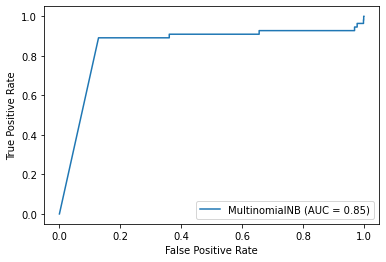

In [54]:
from sklearn.metrics import roc_curve, plot_roc_curve



plot_roc_curve(NB_clfr, NB_test_reviews_vectorized, NB_test['t2_target'])
plt.show()

In [73]:
fpr, tpr, thresholds = roc_curve(NB_test['t2_target'],predict_probas)

thresholds[np.argmax(tpr - fpr)], thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]

(1.0, 1.0)

In [72]:
roc_df = pd.DataFrame(columns=['tpr','fpr'],index=thresholds)
roc_df['tpr'] = tpr
roc_df['fpr'] = fpr
roc_df.loc[roc_df['tpr'] >= 0.9]

,tpr,fpr
9.997284e-01,0.909091,0.360906
9.982834e-01,0.909091,0.407114
9.982831e-01,0.909091,0.407131
9.943001e-01,0.909091,0.441303
9.942992e-01,0.909091,0.441312
...,...,...
1.300885e-35,0.963636,0.999038
1.168215e-35,0.981818,0.999038
3.688107e-55,0.981818,0.999752
1.721259e-55,1.000000,0.999752


In [77]:
predictions = (NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1] > .999999)

recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions)

(0.8909090909090909, 0.0008195213326420364)

In [78]:
understrat_candidates = [1,0.5,0.25,0.1,0.05,0.01]
alpha_candidates = [1,0.5,0.1,0.05,0.01]

multi_index = pd.MultiIndex.from_product([alpha_candidates,understrat_candidates], names=['alpha','sampling_strategy'])
NB_clfr_results = pd.DataFrame(index=multi_index,columns=['roc_auc_score','recall_score','precision_score'])

#undersample = RandomUnderSampler(sampling_strategy=0.1)

#NB_clfr = MultinomialNB(alpha=1)

for understrat in understrat_candidates:
    for alpha in alpha_candidates:
        undersample = RandomUnderSampler(sampling_strategy=understrat,random_state=0)
        
        X_under, y_under = undersample.fit_resample(NB_df_reviews_vectorized, NB_df['m2_target'])

        NB_clfr = MultinomialNB(alpha=alpha)
        NB_clfr.fit(X_under, y_under)
        
        predictions = (NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1] > .999999)
        predict_probas = NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
        #roc_auc_test_scores.append(roc_auc_score(NB_test['t2_target'],predict_probas))
        #recall_test_scores.append(roc_auc_score(NB_test['t2_target'],predictions))
        #precision_test_scores.append(roc_auc_score(NB_test['t2_target'],predictions))
        
        NB_clfr_results['roc_auc_score'].loc[(alpha,understrat)] = roc_auc_score(NB_test['t2_target'],predict_probas)
        NB_clfr_results['recall_score'].loc[(alpha,understrat)] = recall_score(NB_test['t2_target'],predictions)
        NB_clfr_results['precision_score'].loc[(alpha,understrat)] = precision_score(NB_test['t2_target'],predictions)


NB_clfr_results

roc_auc_score recall_score precision_score
alpha sampling_strategy                                           
1.00  1.00                    0.56802            1     0.000250675
      0.50                   0.601372            1     0.000256657
      0.25                   0.708367            1     0.000293286
      0.10                   0.894773            1     0.000615832
      0.05                   0.602529     0.545455      0.00402522
      0.01                 0.00914336            0               0
0.50  1.00                   0.603306            1     0.000256819
      0.50                   0.656581            1     0.000270795
      0.25                   0.791472            1     0.000362393
      0.10                   0.897146     0.927273       0.0010834
      0.05                   0.477356          0.4      0.00378592
      0.01                  0.0298434    0.0181818        0.016129
0.10  1.00                   0.743938            1     0.000321645
      0.50                   0.822944     0.981818     0.000411909
      0.25                   0.852525     0.890909     0.000819521
      0.10                   0.516956     0.490909      0.00182051
      0.05                   0.389804     0.345455      0.00375865
      0.01                  0.0632447    0.0181818      0.00137363
0.05  1.00                   0.777823     0.981818     0.000357509
      0.50                   0.852015     0.981818     0.000494496
      0.25                   0.750742     0.781818     0.000866638
      0.10                   0.471623     0.436364      0.00170952
      0.05                   0.386273     0.327273      0.00339111
      0.01                  0.0695255    0.0181818      0.00125313
0.01  1.00                   0.766708     0.981818     0.000356803
      0.50                   0.836949     0.981818     0.000473211
      0.25                   0.704169     0.745455     0.000699181
      0.10                   0.476165     0.454545      0.00136904
      0.05                   0.352949     0.272727      0.00225768
      0.01                  0.0429445    0.0181818      0.00161031

In [79]:
df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score,mean_rating_at_m1
recipe_id,,,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744,28.360140,4.250000
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270,15.944444,4.333333
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416,27.642857,2.666667
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127,28.749153,5.000000
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300,32.621735,4.277778
...,...,...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198,36.532448,5.000000
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775,26.073707,0.000000
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980,31.076623,NaN


In [93]:
X_train = df.drop(columns=['m2_target','submitted'])
y_train = df['m2_target']

X_train['mean_rating_at_m1'] = X_train['mean_rating_at_m1'].fillna(0)

X_train

,minutes,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score,mean_rating_at_m1
recipe_id,,,,,,,,,,
38,1485,13,4,4,5624,0.800000,0.991975,0.002744,28.360140,4.250000
40,35,8,6,9,5597,0.500000,0.979425,0.004270,15.944444,4.333333
45,80,10,9,3,5627,0.545455,0.918586,0.012416,27.642857,2.666667
46,25,5,6,2,5622,0.888889,0.999701,0.000127,28.749153,5.000000
49,75,22,10,18,5619,0.545455,0.923262,0.011300,32.621735,4.277778
...,...,...,...,...,...,...,...,...,...,...
520055,42,6,13,1,13,0.777778,0.983806,0.003198,36.532448,5.000000
520088,40,9,6,1,11,0.692308,0.945912,0.010775,26.073707,0.000000
520245,35,10,6,0,3,0.636364,0.930048,0.013980,31.076623,0.000000


In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

#LR_clfr = LinearRegression()
DT_clfr = DecisionTreeClassifier()

#cross_val_score(LR_clfr, X_train, y_train, cv=3, scoring='recall'), 
cross_val_score(DT_clfr, X_train, y_train, cv=10, scoring='roc_auc')

array([0.99909742, 0.74974615, 0.49991538, 0.66663846, 0.5       ,
       0.66666667, 0.49997179, 0.5       , 0.74994359, 0.5       ])

In [109]:
DT_clfr = DecisionTreeClassifier().fit(X_train,y_train)

DT_clfr.feature_importances_

array([0.11972144, 0.        , 0.        , 0.35958094, 0.091771  ,
       0.        , 0.14482689, 0.07379471, 0.14604593, 0.06425908])

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

GB_clfr = GradientBoostingClassifier()

cross_val_score(GB_clfr, X_train, y_train, cv=3, scoring='recall')

array([1.   , 0.5  , 0.625])

In [112]:
GB_clfr = GradientBoostingClassifier().fit(X_train,y_train)

GB_clfr.feature_importances_

array([3.11321497e-02, 0.00000000e+00, 0.00000000e+00, 7.94322633e-01,
       3.92226783e-04, 0.00000000e+00, 6.91716517e-02, 9.68186795e-03,
       9.52994707e-02, 0.00000000e+00])

In [123]:
votes = []

for i in range(500):
    undersample = RandomUnderSampler(sampling_strategy=0.25,random_state=i)

    X_under, y_under = undersample.fit_resample(NB_df_reviews_vectorized, NB_df['m2_target'])

    NB_clfr = MultinomialNB(alpha=0.1)
    NB_clfr.fit(X_under, y_under)
        
    voter_preds = NB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
    
    votes.append(voter_preds)
    
predictions = [1 for p in voter_preds]

for i in range(len(predictions)):
    for voter_preds in votes:
        if voter_preds[i] < 0.999999:
            predictions[i] = 0
        
recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions)

(0.45454545454545453, 0.003793051130329237)

In [48]:
from imblearn.ensemble import RUSBoostClassifier

RUSNB_clfr = RUSBoostClassifier(base_estimator=MultinomialNB(alpha=0.1),sampling_strategy=0.25).fit(NB_df_reviews_vectorized, NB_df['m2_target'])

#predictions = RUSNB_clfr.predict(NB_test_reviews_vectorized)
predict_probas = RUSNB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
predictions = (predict_probas >= 0.5)
        #roc_auc_test_scores.append(roc_auc_score(NB_test['t2_target'],predict_probas))
        #recall_test_scores.append(roc_auc_score(NB_test['t2_target'],predictions))
        #precision_test_scores.append(roc_auc_score(NB_test['t2_target'],predictions))
        
roc_auc_score(NB_test['t2_target'],predict_probas), recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions)

(0.4447127404378675, 1.0, 0.00040664833052376305)

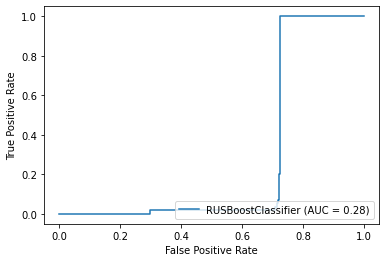

In [44]:
from sklearn.metrics import roc_curve, plot_roc_curve

plot_roc_curve(RUSNB_clfr, NB_test_reviews_vectorized, NB_test['t2_target'])
plt.show()

In [45]:
fpr, tpr, thresholds = roc_curve(NB_test['t2_target'],predict_probas)

thresholds[np.argmax(tpr - fpr)], thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]

(0.5395203732811221, 0.5395203732811221)

In [46]:
RUSNB_predictions = pd.DataFrame(index=NB_test.index,columns={'t2_target','predict_proba','prediction'})
RUSNB_predictions['t2_target'] = NB_test['t2_target']
RUSNB_predictions['predict_proba'] = predict_probas
RUSNB_predictions['prediction'] = predictions

RUSNB_predictions[RUSNB_predictions['t2_target'] == 1]

,prediction,predict_proba,t2_target
recipe_id,,,
4075,True,0.540113,1
4573,True,0.540111,1
5368,True,0.540257,1
15286,True,0.539748,1
15846,True,0.539963,1
17227,True,0.540358,1
21597,True,0.540436,1
22349,True,0.540265,1
25999,True,0.540560,1


In [47]:
len(RUSNB_predictions), len(RUSNB_predictions[RUSNB_predictions['prediction'] == 1]), len(RUSNB_predictions[RUSNB_predictions['t2_target'] == 1])

(229863, 168078, 55)

In [49]:
for i in range(5):
    RUSNB_clfr = RUSBoostClassifier(base_estimator=MultinomialNB(alpha=0.1),sampling_strategy=0.25).fit(NB_df_reviews_vectorized, NB_df['m2_target'])

    predictions = RUSNB_clfr.predict(NB_test_reviews_vectorized)
    predict_probas = RUSNB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
    
    print(roc_auc_score(NB_test['t2_target'],predict_probas), recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions))

0.511008557341148 1.0 0.00047110821784043994
0.9483253213749976 1.0 0.0003626365656339217


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9795069243574083 0.0 0.0


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.975439022614926 0.0 0.0
0.9821875019779357 0.0 0.0


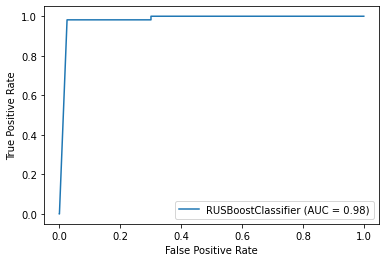

In [50]:
from sklearn.metrics import roc_curve, plot_roc_curve

plot_roc_curve(RUSNB_clfr, NB_test_reviews_vectorized, NB_test['t2_target'])
plt.show()

In [51]:
fpr, tpr, thresholds = roc_curve(NB_test['t2_target'],predict_probas)

thresholds[np.argmax(tpr - fpr)], thresholds[np.argmax(np.sqrt(tpr * (1 - fpr)))]

(0.5, 0.5)

In [52]:
for i in range(5):
    RUSNB_clfr = RUSBoostClassifier(base_estimator=MultinomialNB(alpha=0.1),sampling_strategy=0.25).fit(NB_df_reviews_vectorized, NB_df['m2_target'])

    #predictions = RUSNB_clfr.predict(NB_test_reviews_vectorized)
    predict_probas = RUSNB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
    predictions = (predict_probas > 0.49)
    
    print(roc_auc_score(NB_test['t2_target'],predict_probas), recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions))

0.9682497800535466 1.0 0.0005129496469973792
0.36676292620559137 1.0 0.0003503407860373272
0.9788428917736862 0.9818181818181818 0.008483896307934015
0.6826747862247062 1.0 0.000540057540676152
0.9651752767527675 0.9818181818181818 0.0062269372693726935


In [53]:
for i in range(5):
    RUSNB_clfr = RUSBoostClassifier(base_estimator=MultinomialNB(alpha=0.1),sampling_strategy=0.25).fit(NB_df_reviews_vectorized, NB_df['m2_target'])

    #predictions = RUSNB_clfr.predict(NB_test_reviews_vectorized)
    predict_probas = RUSNB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
    predictions = (predict_probas > 0.49)
    
    print(roc_auc_score(NB_test['t2_target'],predict_probas), recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions))

0.9815785351249738 0.9818181818181818 0.008237986270022883
0.9766607539574538 0.9818181818181818 0.007848837209302326
0.9669433139442887 0.9818181818181818 0.0067941620533467535
0.4628976441994266 1.0 0.0004282521860327496
0.9827511345439355 0.9818181818181818 0.008852459016393442


In [54]:
RUSNB_clfr = RUSBoostClassifier(base_estimator=MultinomialNB(alpha=0.1),sampling_strategy=0.25,random_state=0).fit(NB_df_reviews_vectorized, NB_df['m2_target'])

predict_probas = RUSNB_clfr.predict_proba(NB_test_reviews_vectorized)[:,1]
predictions = (predict_probas > 0.49)

print(roc_auc_score(NB_test['t2_target'],predict_probas), recall_score(NB_test['t2_target'],predictions), precision_score(NB_test['t2_target'],predictions))

0.47038397270765164 1.0 0.00042813550878067005


In [58]:
df['RUSNB_prob_pred'] = RUSNB_clfr.predict_proba(NB_df_reviews_vectorized)[:,1]

df

,m2_target,minutes,submitted,n_steps,n_ingredients,total_ratings_at_m1,age_in_days,innovation_jaccard,innovation_jaccard_avg,innovation_IDF,LIX_score,mean_rating_at_m1,RUSNB_prob_pred
recipe_id,,,,,,,,,,,,,
38,0,1485,1999-08-09,13,4,4,5624,0.800000,0.991975,0.002744,28.360140,4.250000,0.351875
40,0,35,1999-09-05,8,6,9,5597,0.500000,0.979425,0.004270,15.944444,4.333333,0.737501
45,0,80,1999-08-06,10,9,3,5627,0.545455,0.918586,0.012416,27.642857,2.666667,0.778567
46,0,25,1999-08-11,5,6,2,5622,0.888889,0.999701,0.000127,28.749153,5.000000,0.330793
49,0,75,1999-08-14,22,10,18,5619,0.545455,0.923262,0.011300,32.621735,4.277778,0.619147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520055,0,42,2014-12-19,6,13,1,13,0.777778,0.983806,0.003198,36.532448,5.000000,0.020530
520088,0,40,2014-12-21,9,6,1,11,0.692308,0.945912,0.010775,26.073707,0.000000,0.000307
520245,0,35,2014-12-29,10,6,0,3,0.636364,0.930048,0.013980,31.076623,NaN,0.000001


In [60]:
predictions = (df['RUSNB_prob_pred'] > .49)

print(roc_auc_score(df['m2_target'],predictions), recall_score(df['m2_target'],predictions), precision_score(df['m2_target'],predictions))

0.6999949227696856 1.0 0.000225599954880009


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

X_train = df.drop(columns=['m2_target','submitted'])
y_train = df['m2_target']

X_train['mean_rating_at_m1'] = X_train['mean_rating_at_m1'].fillna(0)

#X_train

#LR_clfr = LinearRegression()
DT_clfr = DecisionTreeClassifier()

#cross_val_score(LR_clfr, X_train, y_train, cv=3, scoring='recall'), 
cross_val_score(DT_clfr, X_train, y_train, cv=5, scoring='roc_auc'), cross_val_score(DT_clfr, X_train, y_train, cv=5, scoring='recall'), cross_val_score(DT_clfr, X_train, y_train, cv=5, scoring='precision')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.51311596, 0.62484487, 0.7       , 0.5       , 0.7       ]),
 array([1.  , 0.25, 0.4 , 0.  , 0.2 ]),
 array([1.44814203e-04, 9.09090909e-02, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00]))

In [64]:
DT_clfr = DecisionTreeClassifier().fit(X_train,y_train)

DT_clfr.feature_importances_

array([0.09012463, 0.        , 0.        , 0.35335405, 0.0306414 ,
       0.        , 0.09968189, 0.08699094, 0.16609283, 0.0472531 ,
       0.12586115])

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

GB_clfr = GradientBoostingClassifier()

cross_val_score(GB_clfr, X_train, y_train, cv=5, scoring='roc_auc'), cross_val_score(GB_clfr, X_train, y_train, cv=5, scoring='recall'), cross_val_score(GB_clfr, X_train, y_train, cv=5, scoring='precision')

(array([0.5457084 , 0.24994359, 0.70001128, 0.80000282, 0.29999436]),
 array([1.  , 0.25, 0.6 , 0.8 , 0.  ]),
 array([1.44801622e-04, 3.33333333e-02, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00]))

In [66]:
GB_clfr = GradientBoostingClassifier().fit(X_train,y_train)

GB_clfr.feature_importances_

array([0.        , 0.        , 0.        , 0.77748893, 0.        ,
       0.        , 0.0651632 , 0.01240312, 0.09327983, 0.        ,
       0.05166491])